In [8]:
import pandas as pd

In [9]:
source = pd.read_csv("/content/source_tweets.txt",sep = "\t",names = ["ID","Tweets"])

In [12]:
source.head()

,ID,Tweets
0,731166399389962242,🔥ca kkk grand wizard 🔥 endorses @hillaryclinto...
1,714598641827246081,an open letter to trump voters from his top st...
2,691809004356501505,america is a nation of second chances —@potus ...
3,693204708933160960,"brandon marshall visits and offers advice, sup..."
4,551099691702956032,rip elly may clampett: so sad to learn #beverl...


In [18]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=source)

https://docs.google.com/spreadsheets/d/1vJxEHF6LO1BaHSHRdT2uwOU6anAlSh0TCEDxt41jDu4#gid=0


In [13]:
labels = pd.read_csv("/content/label.txt",sep = ":",names = ["Class","ID"])

In [14]:
labels.head()

,Class,ID
0,unverified,731166399389962242
1,unverified,714598641827246081
2,non-rumor,691809004356501505
3,non-rumor,693204708933160960
4,true,551099691702956032


In [15]:
df = pd.merge(source,labels,on = "ID",how = "inner")
df.head()

,ID,Tweets,Class
0,731166399389962242,🔥ca kkk grand wizard 🔥 endorses @hillaryclinto...,unverified
1,714598641827246081,an open letter to trump voters from his top st...,unverified
2,691809004356501505,america is a nation of second chances —@potus ...,non-rumor
3,693204708933160960,"brandon marshall visits and offers advice, sup...",non-rumor
4,551099691702956032,rip elly may clampett: so sad to learn #beverl...,true


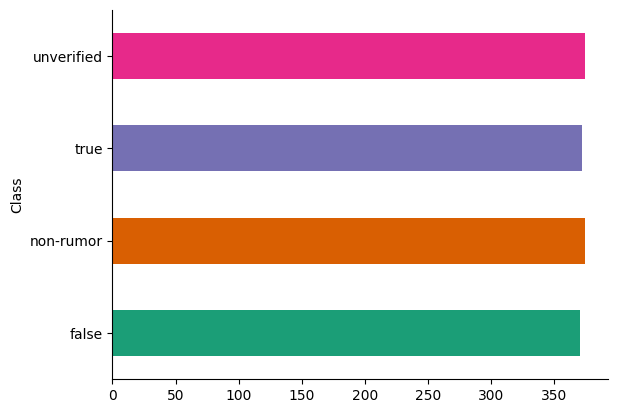

In [20]:
# @title Class

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('Class').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [19]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=df)

https://docs.google.com/spreadsheets/d/1v9IqF15V_K1WgEkSb4a_xTJn5nQC4YYMxe_PJ8r74_8#gid=0


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      1490 non-null   int64 
 1   Tweets  1490 non-null   object
 2   Class   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


In [32]:
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [34]:
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import string

def preprocess_data(text):
  text = text.lower()
  text = text.translate(str.maketrans("","",string.punctuation))
  tokens = word_tokenize(text)

  stemmer = PorterStemmer()
  stopword_list = set(stopwords.words("english"))

  tokenized = [stemmer.stem(token) for token in tokens if token not in stopword_list]
  return tokenized

preprocess_data("🔥ca kkk grand wizard 🔥 endorses @hillaryclinton #neverhillary #trump2016 URL")



['🔥ca',
 'kkk',
 'grand',
 'wizard',
 '🔥',
 'endors',
 'hillaryclinton',
 'neverhillari',
 'trump2016',
 'url']

In [35]:
from collections import defaultdict

def frequency_table(tweets):
  word_count = defaultdict(int)
  for tweet in tweets:
    tokens = preprocess_data(tweet)
    for token in tokens:
      word_count[token]+=1
  return word_count

In [37]:
word_count_true = frequency_table(df[df['Class']=='true']['Tweets'])
word_count_false = frequency_table(df[df['Class']=='false']['Tweets'])
word_count_unverified  = frequency_table(df[df['Class']=='unverified']['Tweets'])
word_count_non_rumor = frequency_table(df[df['Class']=='non-rumor']['Tweets'])


In [38]:
word_count_true

defaultdict(int,
            {'rip': 33,
             'elli': 8,
             'may': 12,
             'clampett': 5,
             'sad': 3,
             'learn': 2,
             'beverlyhillbilli': 1,
             'star': 10,
             'donna': 10,
             'dougla': 10,
             'pass': 3,
             'away': 5,
             'url': 471,
             'miss': 6,
             'afghan': 8,
             'soldier': 37,
             'found': 13,
             'tri': 8,
             'enter': 1,
             'canada': 11,
             'near': 5,
             'niagara': 2,
             'fall': 3,
             'let': 4,
             'friend': 6,
             'know': 4,
             'state': 7,
             'senat': 2,
             'south': 10,
             'carolina': 1,
             'women': 2,
             'lesser': 2,
             'cut': 6,
             'meat': 3,
             'chewonthi': 1,
             'paul': 78,
             'walker': 78,
             'die': 68,
             '

In [43]:
dict_list = [word_count_true, word_count_false, word_count_unverified, word_count_non_rumor]


total_words = {}

for d in dict_list:
    for word, freq in d.items():
        if word in total_words:
            total_words[word] += freq
        else:
            total_words[word] = freq
print(sum(total_words.values()))

16631


In [46]:
def likelihood_word_per_class(word_count,smooth_operator = 1):

  likelihood = {}
  total = sum(word_count.values())
  vocab_size = len(word_count)
  for word,count in word_count.items():
    likelihood[word] = (count+smooth_operator)/(total+ (smooth_operator*vocab_size))
  return likelihood


In [50]:
#Calculating log likelihood
import math
log_likelihood_true = {word: math.log(prob) for word, prob in likelihood_word_per_class(word_count_true).items()}
log_likelihood_false = {word: math.log(prob) for word, prob in likelihood_word_per_class(word_count_false).items()}
log_likelihood_unverified  = {word: math.log(prob) for word, prob in likelihood_word_per_class(word_count_unverified).items()}
log_likelihood_non_rumor = {word: math.log(prob) for word, prob in likelihood_word_per_class(word_count_non_rumor).items()}

In [53]:
#Calculating log prior probabilities
def calculate_prior_prob(label,df):
  log_prob = math.log(len(df[df["Class"]==label])/len(df))
  return log_prob
prior_true = calculate_prior_prob("true",df)
prior_false = calculate_prior_prob("false",df)
prior_unverified = calculate_prior_prob("unverified",df)
prior_non_rumor = calculate_prior_prob("non-rumor",df)

In [55]:
#Rumor Detection of the tweets
def rumor_detection(tweets,prior_true,prior_false,prior_unverified,prior_non_rumor,log_likelihood_true,log_likelihood_false,log_likelihood_unverified,log_likelihood_non_rumor):
  tokens = preprocess_data(tweets)
  log_true_score = prior_true+ sum([log_likelihood_true.get(token,0) for token in tokens])
  log_false_score = prior_true+ sum([log_likelihood_false.get(token,0) for token in tokens])
  log_unverified_score = prior_true+ sum([log_likelihood_unverified.get(token,0) for token in tokens])
  log_non_rumor_score = prior_true+ sum([log_likelihood_non_rumor.get(token,0) for token in tokens])

  classification = {
      "true":log_true_score,
      "false":log_false_score,
      "unverified":log_unverified_score,
      "non_rumor":log_non_rumor_score
  }
  return max(classification,key = classification.get)
rumor_detection("🔥ca kkk grand wizard 🔥 endorses @hillaryclinton #neverhillary #trump2016 URL",prior_true,prior_false,prior_unverified,prior_non_rumor,log_likelihood_true,log_likelihood_false,log_likelihood_unverified,log_likelihood_non_rumor)

'true'